<h1><center>Problem 3</center></h1>

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">
<button>Toggle Code</button></a>''')

In [2]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
    Load in stimulus and spike files
"""
# load stimulus
with open('stimulus.txt','r') as f:
    # create list to store stimulus
    stimulus = []
    # read in every line of file, split into list pairs, convert to float (seconds)
    for line in f:
        stimulus.append([float(v)/1000 for v in line.rstrip().split('\t')])

# load spike file
with open('spikes.txt','r') as f:
    # create list to store spikes
    spikes = []
    # read in every line of file, converting to float
    for line in f:
        spikes.append(float(line.rstrip()))
        
# find the start of each 20 s trial
trial_start = [] # list to store index of start of each trial
trial_start.append(0) # we know first trial starts at first index
trial_num = 1 # look for start of 2nd trial
for n,spike in enumerate(spikes):
    if spike >= trial_num*20: # look for start of trial
        # append start of trail and increment to next trial
        trial_start.append(n)
        trial_num += 1
    if trial_num == 5: # quit after finding 5th trial
        break
# define trial ends
trial_end = trial_start[1:5] + [len(spikes)]

# split trials
trial = [] # list to store each trial
for n,(start,end) in enumerate(zip(trial_start,trial_end)):
    # append spikes to trial list, subtract offset time to get
    # 0 - 20s range
    trial.append([s-n*20 for s in spikes[start:end]])

In [4]:
"""
    Create S and R matrices
"""
# create Bins to loop over
class Bins:
    """
        Creates bins with generator to iterate over.
        NOTE: start and end parameters of gen method correspond to the units of 
        step to the END of first and last bin rather than the START
    """
    def gen(self,start,end,step,size,dtype=float): # this method generates bins
        # Create bins from start to end units, with step size (step), and size n units (size)
        for t in range(start,end):
            yield ((dtype(t)-size)*step,dtype(t)*step) # bin interval
        
# Discretize stimulus by binning values in 0.1s intervals
stimulus_d = []
for t in Bins().gen(1,201,0.1,1): # loop 20s in 0.1s step
    # overlap flag
    overlap = False
    # for each interval in stimulus check if it is in the bin interval
    for s in stimulus:
        # overlap if start of stimulus if before end of bin and end is before start
        if s[0] <= t[1] and s[1] >= t[0]:
            overlap = True
            break
    # assign 1 if overlap, 0 otherwise
    if overlap:
        stimulus_d.append(1)
    else:
        stimulus_d.append(0)

# Create the S matrix
S = []
# Loop over indicies of 2s bins in 0.1 increments (20s total time)
for i in Bins().gen(20,201,1,20,dtype=int):
    S.append(stimulus_d[i[0]:i[1]])
S = np.array(S) # convert to numpy array

# Create the R matrix
R = []
# Loop over time intervals of 2s bins in 0.1 increments (20s total time)
for b in Bins().gen(20,201,0.1,1):
    # create row to add to R
    row = []
    # loop over all trials
    for t in trial:
        # keep track of spike counts
        spike_count = 0
        # loop over spike time in trial
        for s in t: #
            # overlap if spike in bin interval
            if s <= b[1] and s >= b[0]:
                spike_count += 1
        # append spike_count to the R matrix row
        row.append(spike_count)
    # add row to R
    R.append(row)
R = np.array(R) # convert to numpy array

In [5]:
"""
    Fit LN Model
"""
# Split into model and test data
R_model = np.mean(R[:,0:4], axis=1) # Do mean over the 4 trials
R_test = R[:,4]

# Calculate pseudo-inverse of S matrix
invS = np.linalg.pinv(S)

# Calculate W
W = np.matmul(invS,R_model)

# Create piecewise nonlinear function
filter_output = np.matmul(S,W)
idx = np.argsort(filter_output) # sort filter output
filter_output = filter_output[idx]
R_sort = R_model[idx]
gbins = []
firerate = []
pts = 10 # do every 10 points
# Average r and g across bin, we also round to the nearest integer
for p in range(int(filter_output.shape[0]/pts)):
    gbins.append(np.mean(filter_output[p*pts:(p+1)*pts]))
    firerate.append(np.mean(R_sort[p*pts:(p+1)*pts]))
# Average what is leftover in the last bin 
gbins.append(np.mean(filter_output[(p+1)*pts:]))
firerate.append(np.mean(R_sort[(p+1)*pts:]))

# Create nonlinear function, outputs closest g value in piecewise function
def nonlin(x, b=gbins, f=firerate):
    a = [] # temp array to store values
    for v in x: # loop through all points in input
        # Find bin closest to input x
        _, i = min((val, idx) for (idx, val) in enumerate([abs(i-v) for i in b]))
        # append firerate at that index
        a.append(f[i])
    # return the array
    return np.array(a)

# Calculate times and the LN model output
filter_time = [float(t)/10 for t in range(W.shape[0])] 
time = [float(t)/10 for t in range(R_test.shape[0])]
LN_model = nonlin(np.matmul(S,W))

#### Methods

We implement a LN model to model the spiking behavior of a neuron. The given stimulus for each of the 5 trials was transformed into a stimulus matrix. Each row of the stimulus matrix is a 2 second window on the stimulus vector, starting from the 0 - 2 s interval and increasing by 100 ms each row. For the response vector, we used the first 4 trials for building our model, while the 5th model was used as a comparison. The linear portion of the LN model was built by minimizing the square error between the response vector, $R$, and the matrix product of the stimulus matrix, $S$, and linear filter, $W$. To solve this system, we find the pseudo-inverse of $S$, and matrix multiply it with the response vector $R$, allowing use to find the best fit linear filter, $W$, to the data.

$$ W = (S^{T}S)^{-1}S^{T}R $$

For the non-linear portion of the model, we build a piecewise function by plotting the linear model output vs. the model response vector. After sorting the values of the plot, we bin every 10 points of the sorted plot, averaging the values in each bin to create a piecewise nonlinear function that maps the linear output to a non-linear output. We plot the output of the LN model against the response vector of the 5th trial for comparison.

<h4><center>(i) LN Model</center></h4>

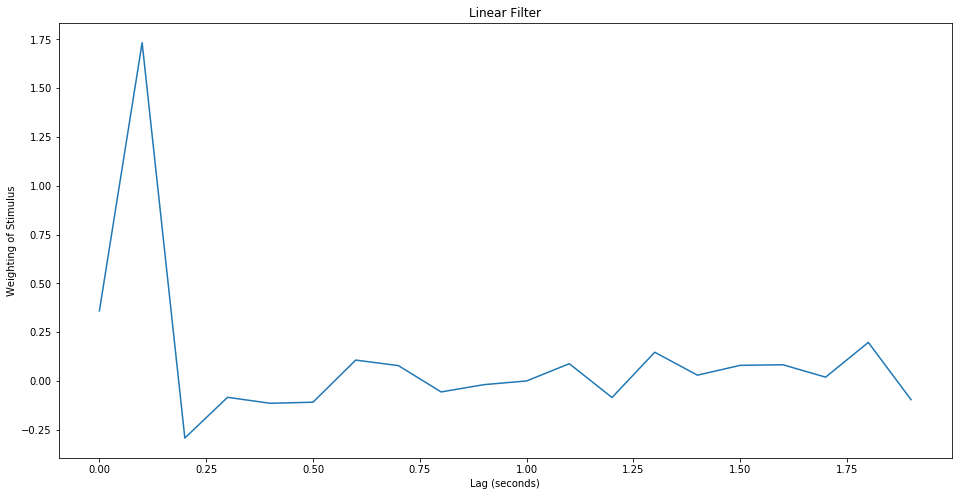

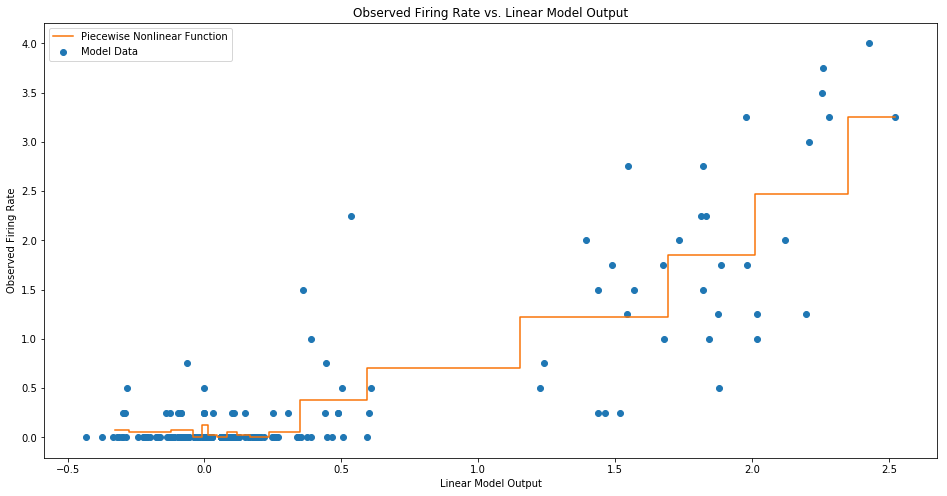

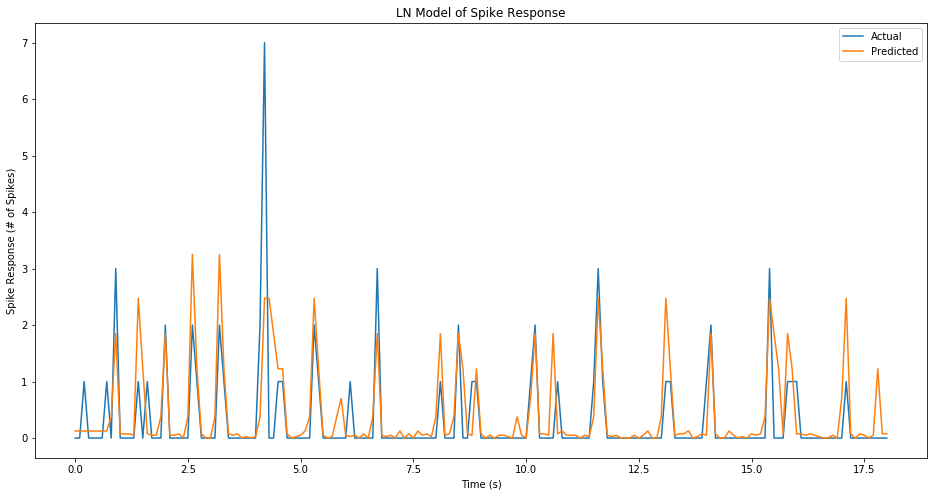

In [6]:
"""
    Plot Everything
"""

# Plot the filter
plt.figure(figsize=(16,8))
plt.plot(filter_time, np.flip(W, axis=0)) # We flip the axis to make the plot nicer
plt.title('Linear Filter')
plt.xlabel('Lag (seconds)')
plt.ylabel('Weighting of Stimulus')
plt.show()

# Plot R_model against Filter Output
plt.figure(figsize=(16,8))
plt.scatter(filter_output, R_sort, label='Model Data')
plt.step(gbins, firerate, 'xkcd:orange', where='mid', label='Piecewise Nonlinear Function')
plt.title('Observed Firing Rate vs. Linear Model Output')
plt.xlabel('Linear Model Output')
plt.ylabel('Observed Firing Rate')
plt.legend()
plt.show()

# Plot the LN model output
plt.figure(figsize=(16,8))
plt.plot(time, R_test, label='Actual')
plt.plot(time, LN_model, label='Predicted')
plt.title('LN Model of Spike Response')
plt.xlabel('Time (s)')
plt.ylabel('Spike Response (# of Spikes)')
plt.legend()
plt.show()

#### Discussion

Examination of the linear filter reveals that the weight of the stimulus is highest very close (temporally) to the response of the spike. This seems to indicate that the past values of the stimulus contribute little to the spike response. The non-linear portion of the model seems to indicate that linear model slighlty underestimates the spike response. The non-linear step corrects for this by creating the appropriate mapping from the the linear output to the predicted firing rate. Finally, when we compare the output of the LN model to the spike response of the 5th trial we can see that it mostly predicts the firing rate fairly well, excluding outliers (e.g. the 5th trial spike respinse peak at around 4 s).